<a href="https://colab.research.google.com/github/10sneha/Energy-Consumption/blob/main/Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENERGY CONSUMPTION PREDICTION USING LSTM

In [ ]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

###DOWNLOADING DATASET

In [ ]:
#dataset from github
!wget https://github.com/10sneha/Energy-Consumption/raw/main/individual%2Bhousehold%2Belectric%2Bpower%2Bconsumption.zip

--2024-07-05 17:37:55--  https://github.com/10sneha/Energy-Consumption/raw/main/individual%2Bhousehold%2Belectric%2Bpower%2Bconsumption.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/10sneha/Energy-Consumption/main/individual%2Bhousehold%2Belectric%2Bpower%2Bconsumption.zip [following]
--2024-07-05 17:37:56--  https://raw.githubusercontent.com/10sneha/Energy-Consumption/main/individual%2Bhousehold%2Belectric%2Bpower%2Bconsumption.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/zip]
Saving to: ‘individual+household+electric+power+consumption.zip.1’

individual

In [ ]:
#extract dataset
import zipfile
with zipfile.ZipFile('individual+household+electric+power+consumption.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted')

In [ ]:
#dataframe
file_path = '/content/extracted/household_power_consumption.txt'

df = pd.read_csv(file_path, sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
print(df.head(5))

<ipython-input-22-82a4b111d95e>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=';',
<ipython-input-22-82a4b111d95e>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, sep=';',


             datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


###DATA PREPROCESSING

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
#Check for null values in each column
null_values = df.isnull().sum()
null_df = pd.DataFrame(null_values, columns=['Null Values'])

#Check for missing values in each column
missing_values = df.isna().sum()
missing_df = pd.DataFrame(missing_values, columns=['Missing Values'])

comparison_df = pd.concat([null_df, missing_df], axis=1)
print("Null and Missing Values per Column:")
print(comparison_df)

Null and Missing Values per Column:
                       Null Values  Missing Values
datetime                         0               0
Global_active_power          25979           25979
Global_reactive_power        25979           25979
Voltage                      25979           25979
Global_intensity             25979           25979
Sub_metering_1               25979           25979
Sub_metering_2               25979           25979
Sub_metering_3               25979           25979


In [ ]:
# Forward fill and then backward fill to handle any remaining missing values
df = df.ffill().bfill()

# Verify that there are no more missing values
null_counts = df.isnull().sum()

# Display the null counts
print("Null and Missing Values per Column:")
print(null_counts)

# Display the first few rows of the dataframe
print(df.head())

Null and Missing Values per Column:
datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
             datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0     

In [ ]:
print(df.describe())

                            datetime  Global_active_power  \
count                        2075259         2.075259e+06   
mean   2008-12-06 07:12:59.999994112         1.086168e+00   
min              2006-12-16 17:24:00         7.600000e-02   
25%              2007-12-12 00:18:30         3.080000e-01   
50%              2008-12-06 07:13:00         5.980000e-01   
75%              2009-12-01 14:07:30         1.524000e+00   
max              2010-11-26 21:02:00         1.112200e+01   
std                              NaN         1.053172e+00   

       Global_reactive_power       Voltage  Global_intensity  Sub_metering_1  \
count           2.075259e+06  2.075259e+06      2.075259e+06    2.075259e+06   
mean            1.233280e-01  2.408416e+02      4.604226e+00    1.110995e+00   
min             0.000000e+00  2.232000e+02      2.000000e-01    0.000000e+00   
25%             4.800000e-02  2.390000e+02      1.400000e+00    0.000000e+00   
50%             1.000000e-01  2.410200e+02      2.

###EDA

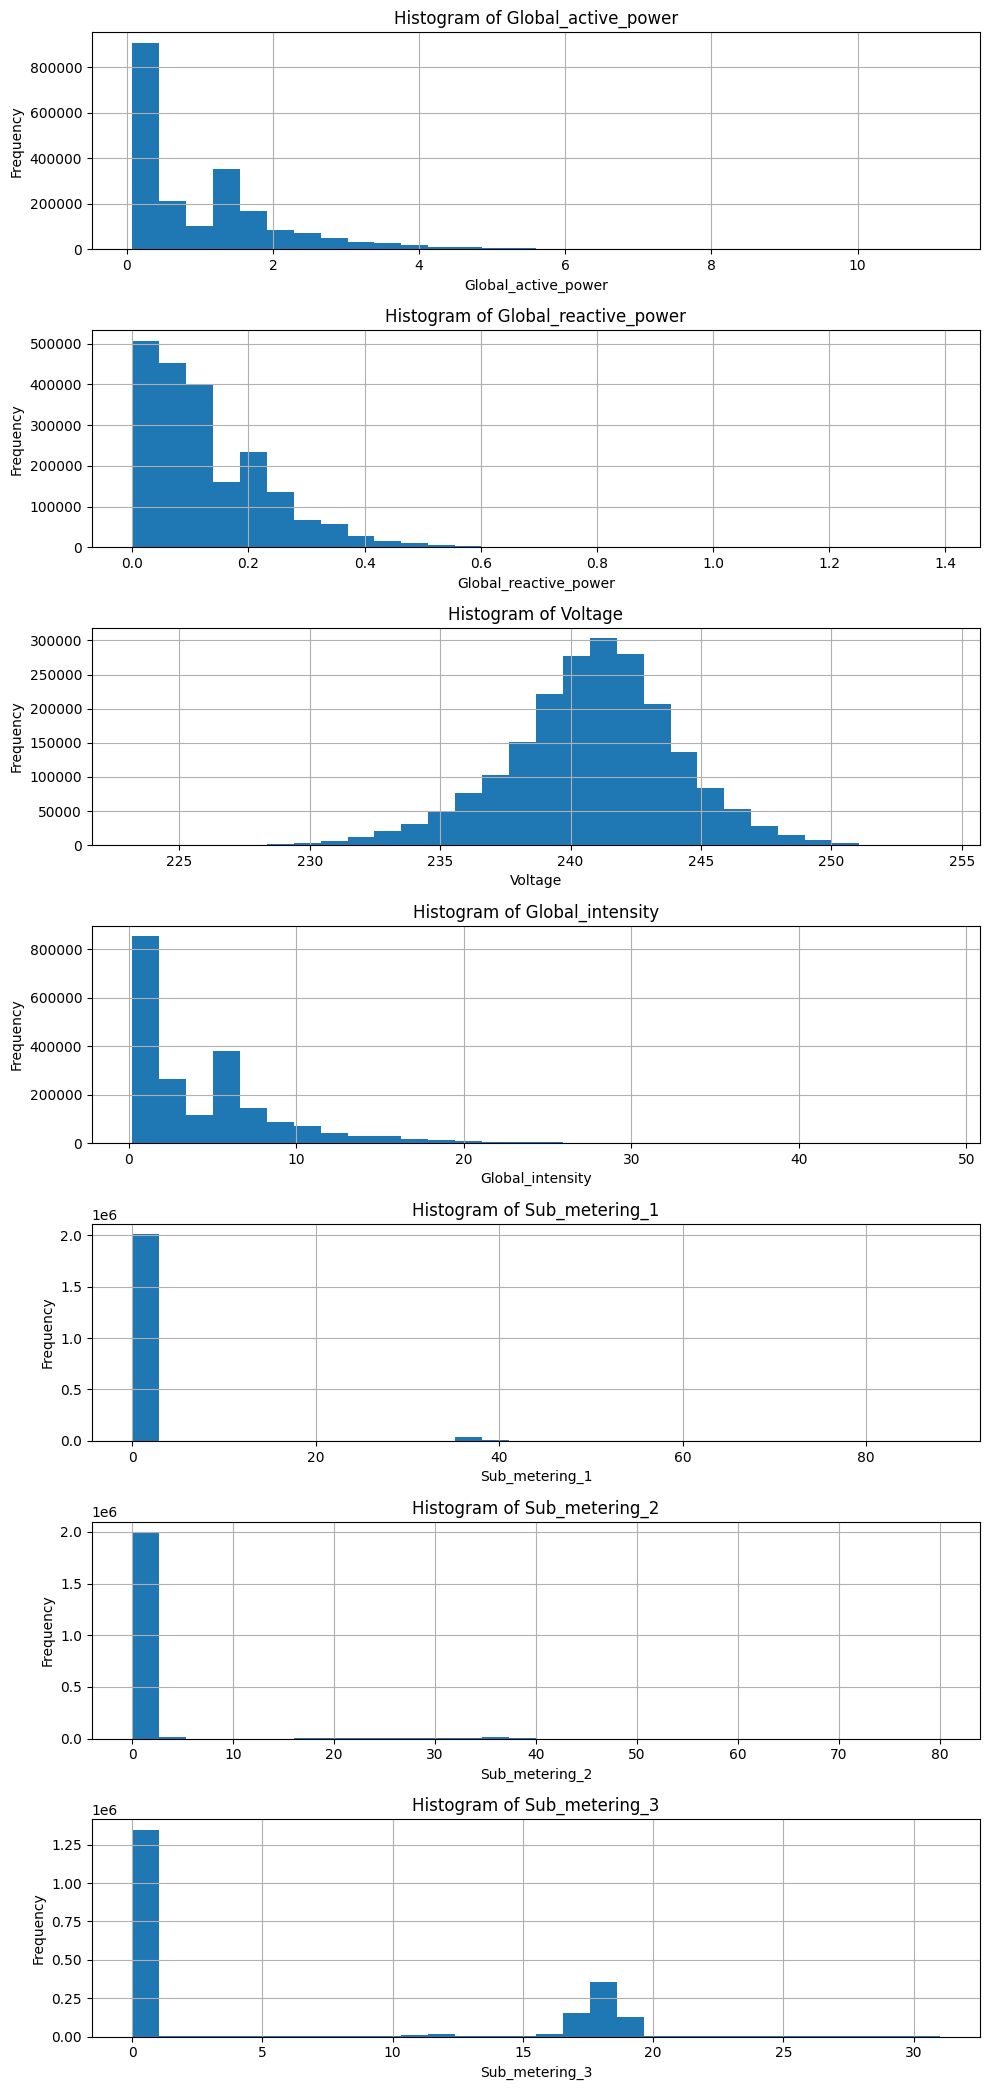

In [ ]:
#plotting histograms of each numeric column
def plot_histograms(df):
    n_cols = len(df.columns)
    fig, axes = plt.subplots(n_cols, 1, figsize=(10, n_cols*3))

    for i, col in enumerate(df.columns):
        ax = axes[i] if n_cols > 1 else axes
        df[col].hist(bins=30, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_histograms(df.drop(columns=['datetime']))

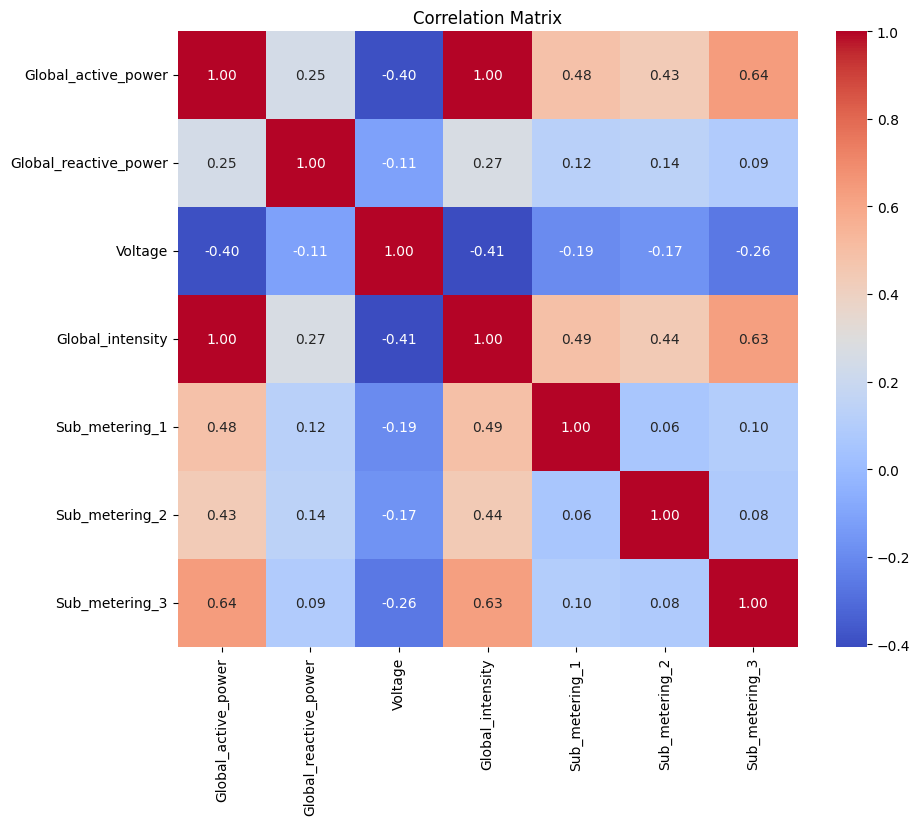

In [ ]:
#plotting correlation matrix
def plot_corr_matrix(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
plot_corr_matrix(df.drop(columns=['datetime']))

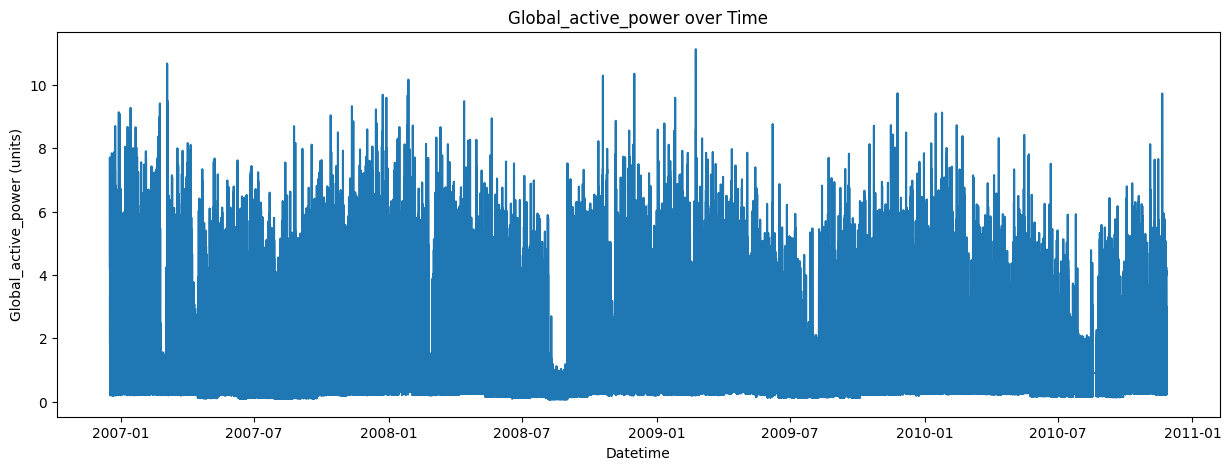

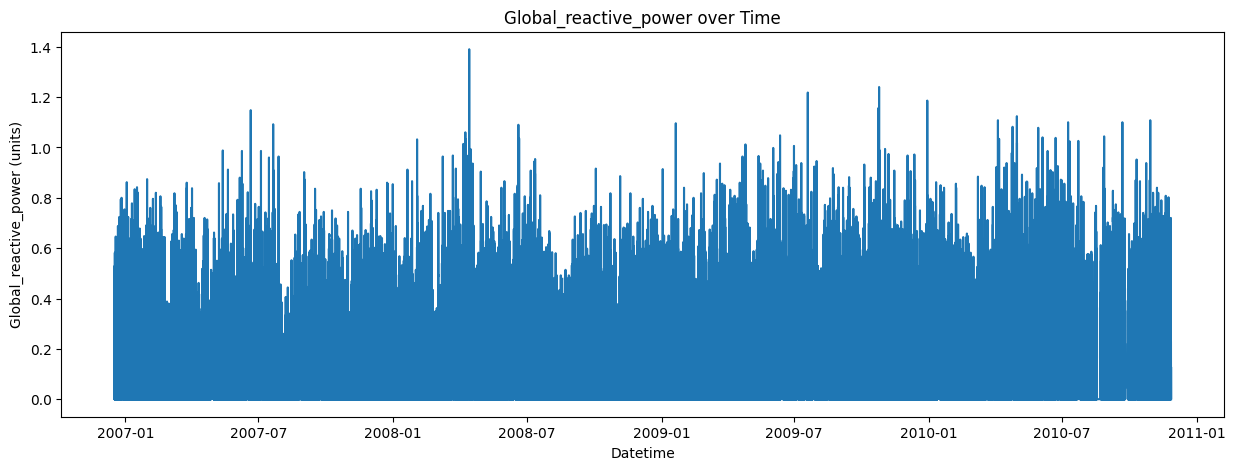

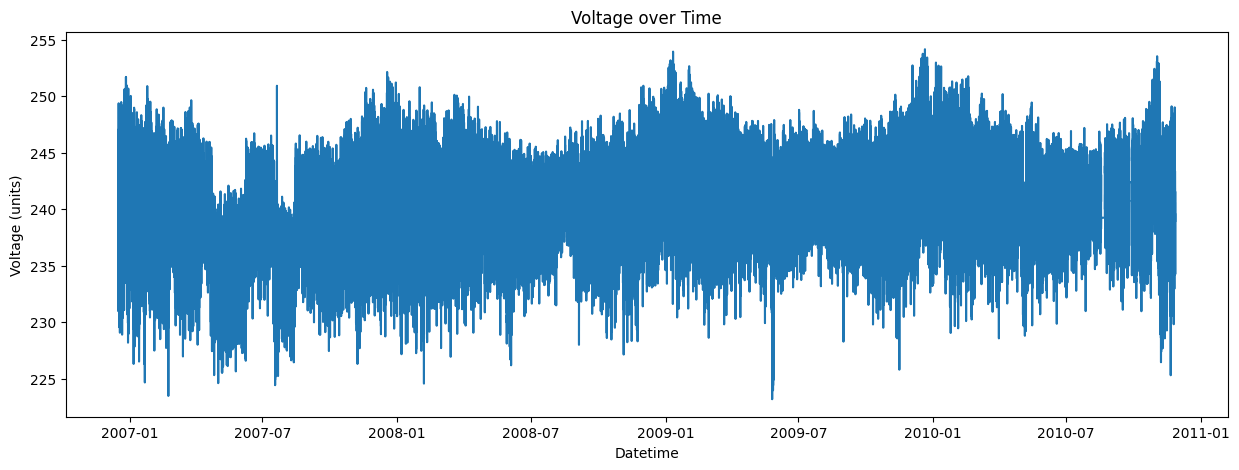

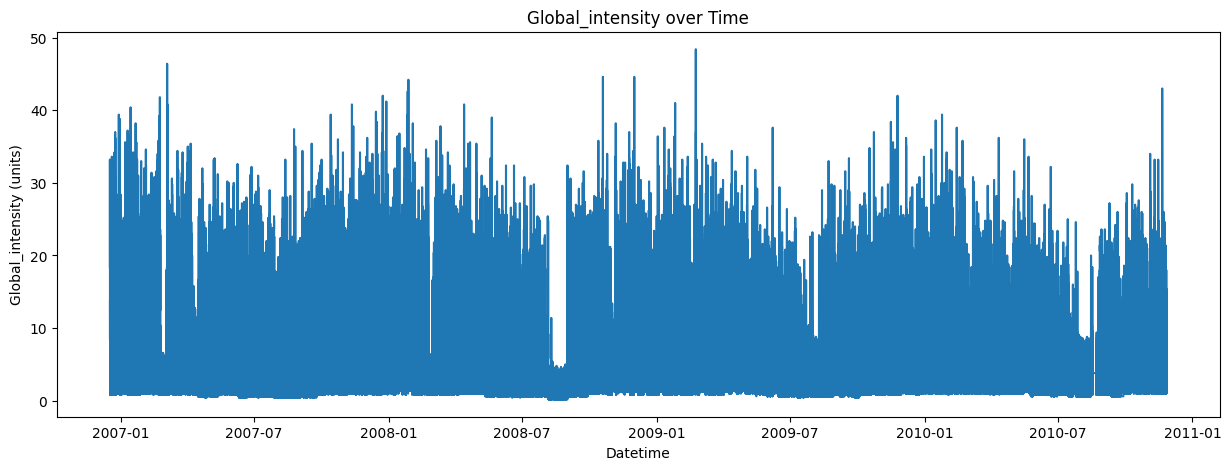

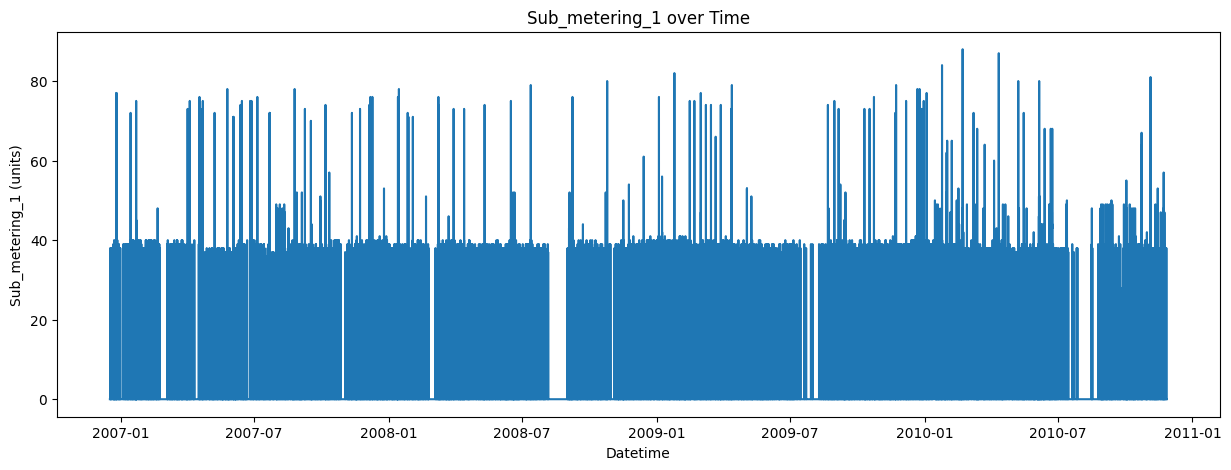

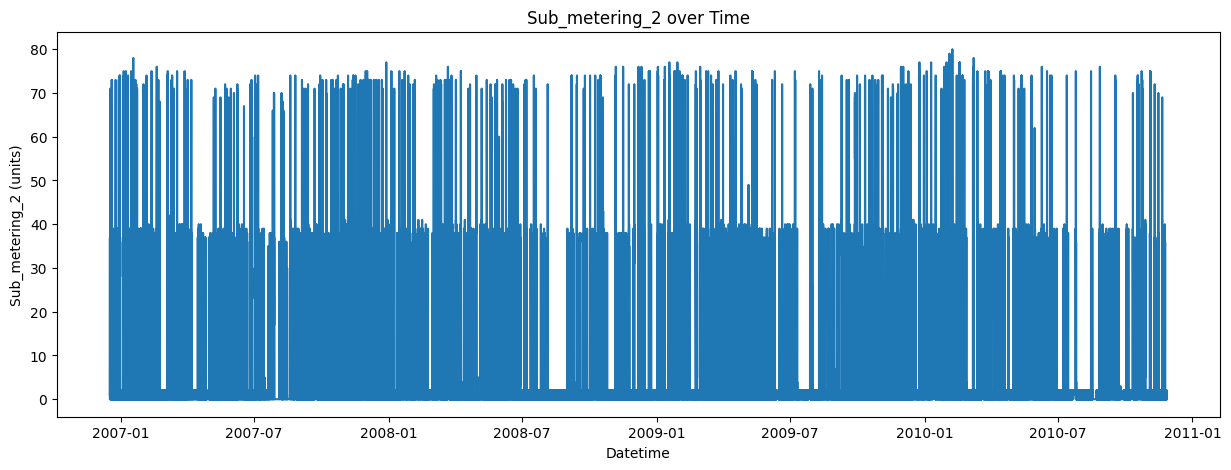

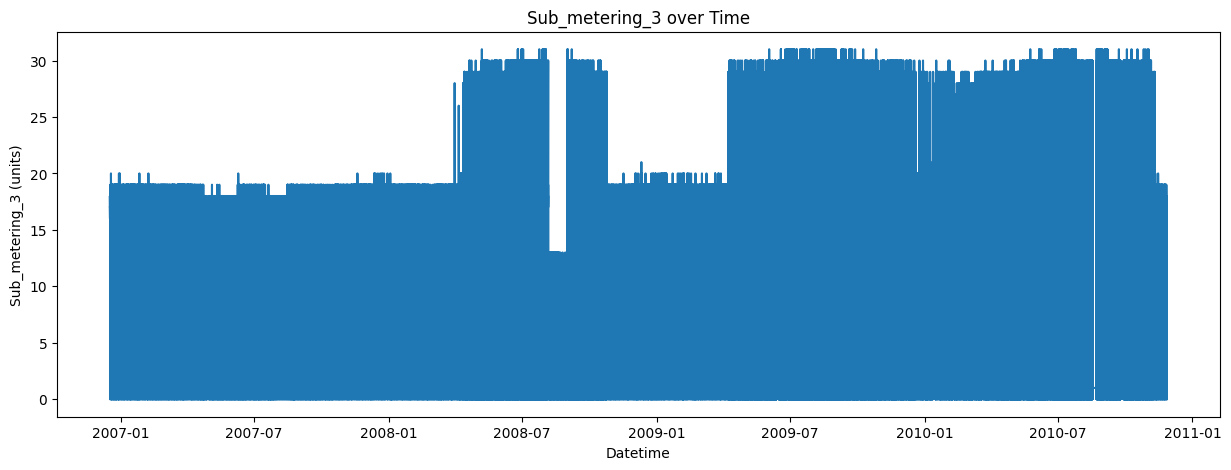

In [ ]:
#plotting time series for features
def plot_time_series(df, features, datetime_col='datetime'):
    for feature in features:
        plt.figure(figsize=(15, 5))
        plt.plot(df[datetime_col], df[feature])
        plt.title(f'{feature} over Time')
        plt.xlabel('Datetime')
        plt.ylabel(f'{feature} (units)')
        plt.show()

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
plot_time_series(df, features)

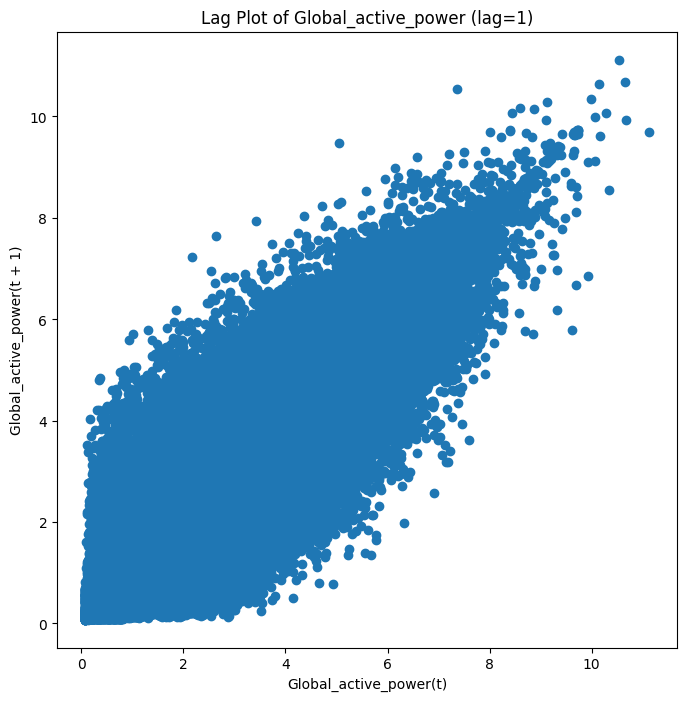

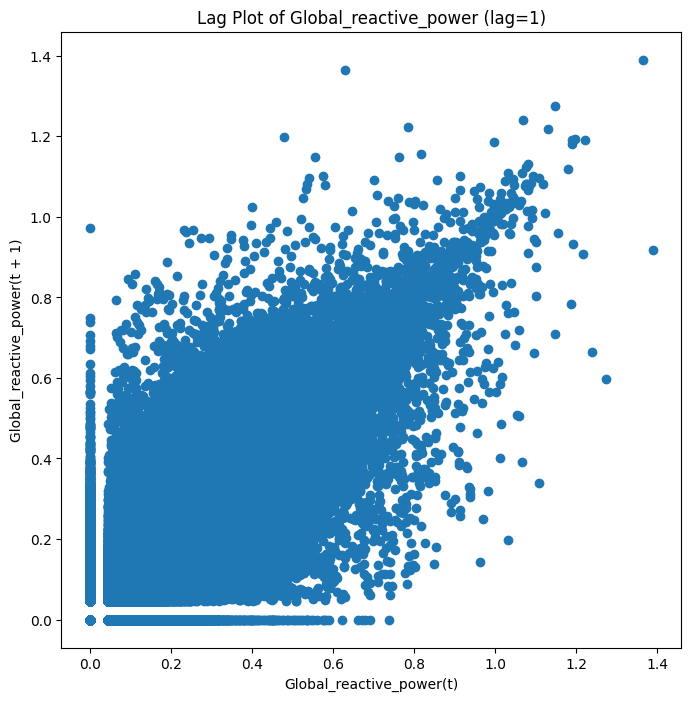

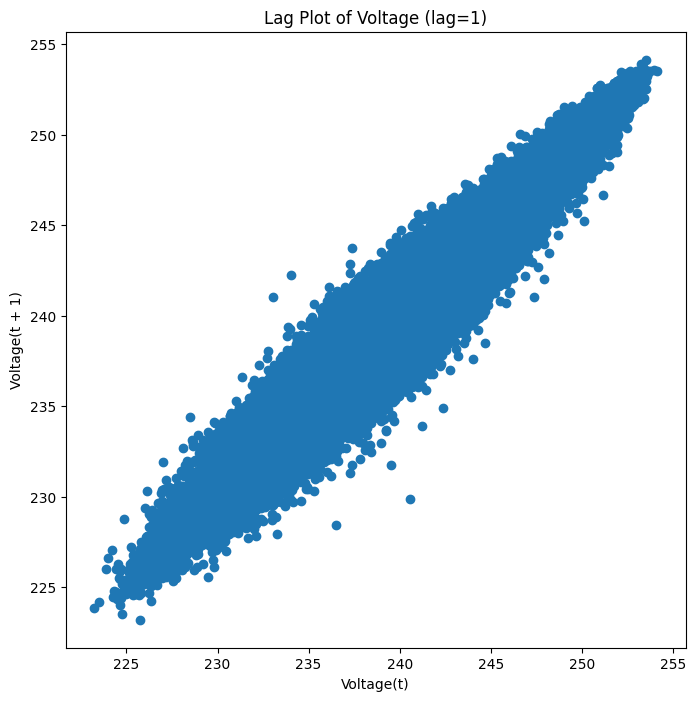

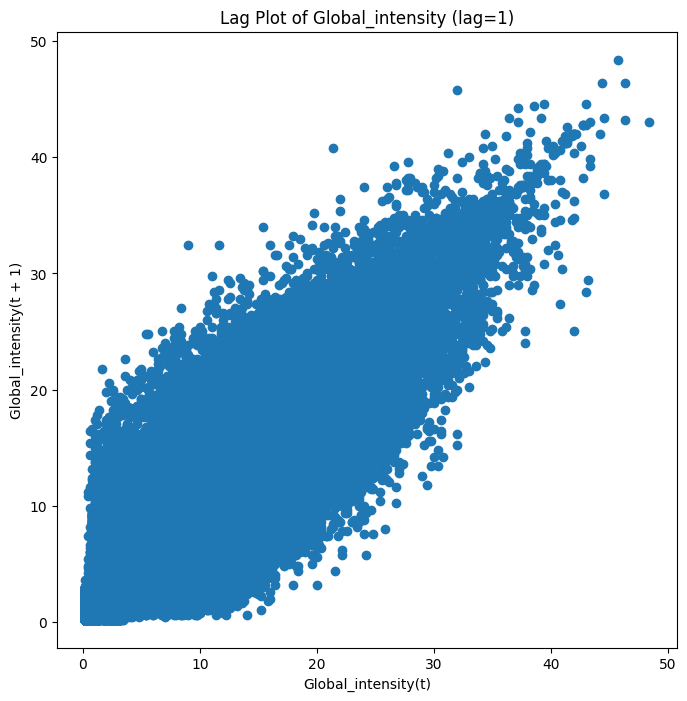

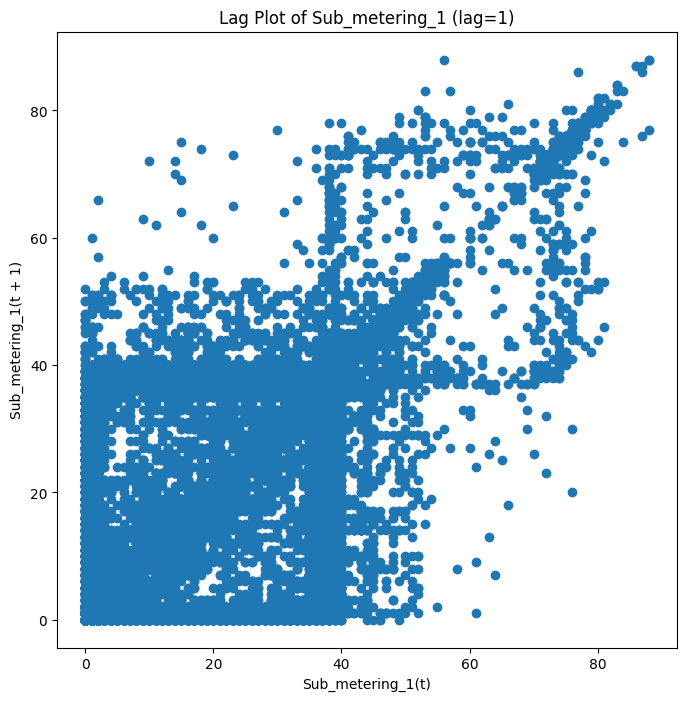

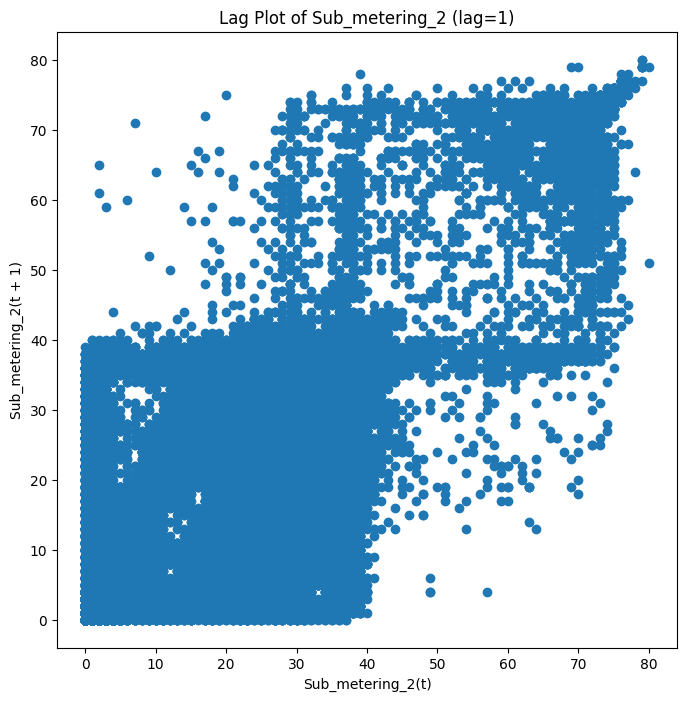

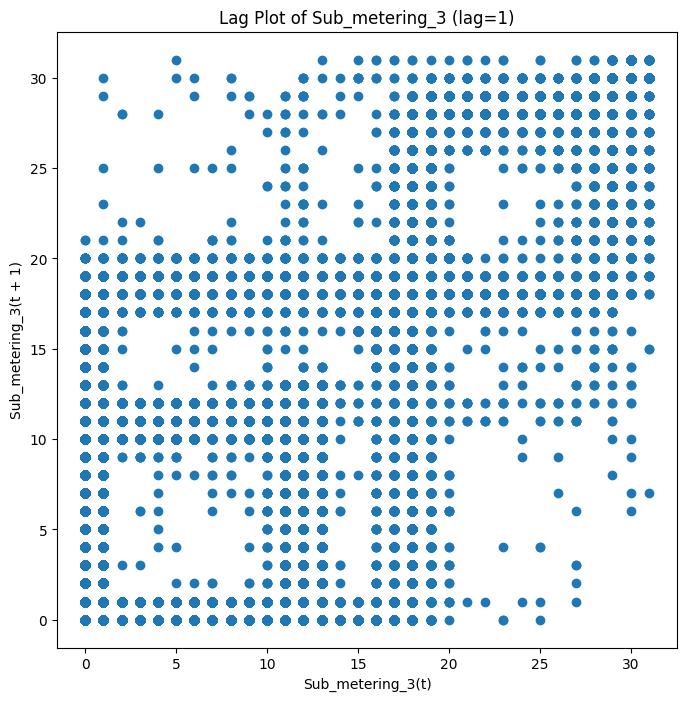

In [ ]:
#plotting lag plots
def plot_lag_plots(df, features, lag=1):
    for feature in features:
        plt.figure(figsize=(8, 8))
        lag_plot(df[feature], lag=lag)
        plt.title(f'Lag Plot of {feature} (lag={lag})')
        plt.xlabel(f'{feature}(t)')
        plt.ylabel(f'{feature}(t + {lag})')
        plt.show()

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
plot_lag_plots(df, features)

###FEATURE ENGINEERING

In [ ]:
#scaling the features
features_to_scale = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [ ]:
#adding lag features
for lag in range(1, 4):
    df[f'Global_active_power_lag_{lag}'] = df['Global_active_power'].shift(lag)
    df[f'Global_reactive_power_lag_{lag}'] = df['Global_reactive_power'].shift(lag)
    df[f'Voltage_lag_{lag}'] = df['Voltage'].shift(lag)
    df[f'Global_intensity_lag_{lag}'] = df['Global_intensity'].shift(lag)
    df[f'Sub_metering_1_lag_{lag}'] = df['Sub_metering_1'].shift(lag)
    df[f'Sub_metering_2_lag_{lag}'] = df['Sub_metering_2'].shift(lag)
    df[f'Sub_metering_3_lag_{lag}'] = df['Sub_metering_3'].shift(lag)

df.dropna(inplace=True)

print(df.head())

              datetime  Global_active_power  Global_reactive_power   Voltage  \
6  2006-12-16 17:30:00             2.483765               3.525524 -1.777616   
7  2006-12-16 17:31:00             2.481866               3.525524 -1.737438   
8  2006-12-16 17:32:00             2.451482               3.436646 -2.117587   
9  2006-12-16 17:33:00             2.445785               3.436646 -2.157765   
10 2006-12-16 17:34:00             3.192102               3.329993 -2.466829   

    Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
6           2.529104       -0.181657       -0.049761        1.257014   
7           2.529104       -0.181657       -0.049761        1.257014   
8           2.529104       -0.181657       -0.049761        1.257014   
9           2.529104       -0.181657        0.123044        1.138242   
10          3.387517       -0.181657       -0.049761        1.257014   

    Global_active_power_lag_1  Global_reactive_power_lag_1  ...  \
6                  

In [ ]:
#split data into features and target
X = df.drop(columns=['datetime', 'Global_active_power'])
y = df['Global_active_power']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

###MODEL BUILDING AND TRAINING

In [ ]:
#building the LSTM Model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

y_pred_lstm = model.predict(X_test_lstm).reshape(-1)

# Compute metrics
rmse_lstm = mean_squared_error(y_test, y_pred_lstm, squared=False)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f'LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}, MAPE: {mape_lstm}, R²: {r2_lstm}')

Epoch 1/50
51882/51882 [==============================] - 376s 7ms/step - loss: 0.0573 - val_loss: 0.0069
Epoch 2/50
51882/51882 [==============================] - 370s 7ms/step - loss: 0.0454 - val_loss: 0.0093
Epoch 3/50
51882/51882 [==============================] - 377s 7ms/step - loss: 0.0436 - val_loss: 0.0044
Epoch 4/50
51882/51882 [==============================] - 373s 7ms/step - loss: 0.0428 - val_loss: 0.0032
Epoch 5/50
51882/51882 [==============================] - 353s 7ms/step - loss: 0.0418 - val_loss: 0.0111
Epoch 6/50
51882/51882 [==============================] - 366s 7ms/step - loss: 0.0416 - val_loss: 0.0051
Epoch 7/50
51882/51882 [==============================] - 361s 7ms/step - loss: 0.0410 - val_loss: 0.0117
Epoch 8/50
51882/51882 [==============================] - 365s 7ms/step - loss: 0.0411 - val_loss: 0.0211
Epoch 9/50
51882/51882 [==============================] - 343s 7ms/step - loss: 0.0409 - val_loss: 0.0086
Epoch 10/50
51882/51882 [=====================

###MODEL EVALUATION

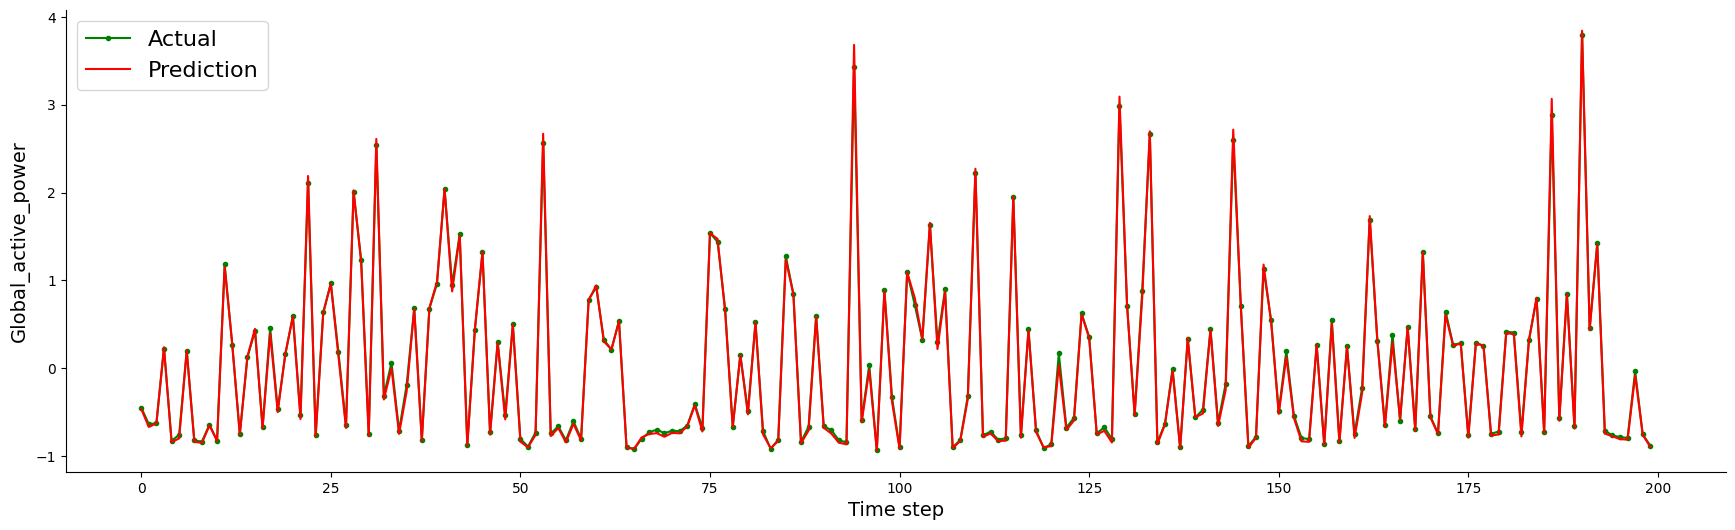

In [ ]:
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_lstm_array = y_pred_lstm if hasattr(y_pred_lstm, 'values') else y_pred_lstm

# Ensure the length is sufficient for slicing
if len(y_test_array) >= 200 and len(y_pred_lstm_array) >= 200:
    aa = list(range(200))  # Time steps for plotting

    plt.figure(figsize=(20,6))
    plt.plot(aa, y_test_array[:200], marker='.', label="Actual", color='green')
    plt.plot(aa, y_pred_lstm_array[:200], '-', label="Prediction", color='red')

    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Global_active_power', size=14)
    plt.xlabel('Time step', size=14)
    plt.legend(fontsize=16)
    plt.show()
else:
    print("Insufficient data points for plotting")